In [54]:
# !unzip in_data/data-compressed.zip

In [55]:
#imports, need to only run this once
!pip3 install numpy 
!pip3 install pandas 
!pip3 install torch torchvision 
!pip3 install scikit-learn
!pip3 install xgboost
!pip3 install category_encoders
!pip3 install shap

# Softmax

In [56]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split

D_PATH = 'lish-moa/'

train_features = pd.read_csv(D_PATH + 'train_features.csv')
train_drug  = pd.read_csv(D_PATH + 'train_drug.csv')
test_features = pd.read_csv(D_PATH + 'test_features.csv')
train_targets_scored = pd.read_csv(D_PATH + 'train_targets_scored.csv' )
train_targets_nonscored = pd.read_csv(D_PATH + 'train_targets_nonscored.csv' )

tr_mask = train_features['cp_type']=='ctl_vehicle'
ts_mask = test_features['cp_type']=='ctl_vehicle'

# replace str to binary
train_features['cp_dose'] = train_features['cp_dose'].replace({'D1': 0, 'D2': 1})
train_features['cp_type'] = train_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})
test_features['cp_dose'] = test_features['cp_dose'].replace({'D1': 0, 'D2': 1})
test_features['cp_type'] = test_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})

# Exclude rows where cp_type is "ctl_vehicle"
X = train_features[~tr_mask]
y = train_targets_scored[~tr_mask]


#removing sig_id column 
X = X.iloc[:, 1:].to_numpy()
submission_X_test = test_features.iloc[:, 1:].to_numpy() #only for the final submission
y = y.iloc[:, 1:].to_numpy()

#we are going to fake making a train, dev and test set 
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.3333, random_state=42)

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming X and y are your input features and labels respectively

# Define your model architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out


def train(model, train_loader, num_epochs, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # No need to convert labels to float here
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

 

def evaluate(model, test_loader, criterion):
    # Set the model in evaluation mode
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            # Convert probabilities to binary predictions
            predicted_labels = (outputs > 0.5).float()

            # Store true and predicted labels for later computation
            true_labels.extend(labels.cpu().numpy().flatten())
            pred_labels.extend(predicted_labels.cpu().numpy().flatten())

            # Compute accuracy
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)*labels.size(1)

            

    # Calculate average loss
    average_loss = total_loss / len(test_loader.dataset)

    # Calculate accuracy
    accuracy = total_correct / total_samples

    # Calculate precision, recall, and F1 score using scikit-learn
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    print(f"Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


#Define loss function and optimizer
model = MultiLabelClassifier(input_size=X.shape[1], num_classes=206)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Convert labels to probabilities
y_train_prob = y.astype(np.float32)  # Convert to float for torch.tensor
y_test_prob = y_test.astype(np.float32)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_prob, dtype=torch.float32)  # Use probabilities
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_prob, dtype=torch.float32)  # Use probabilities

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Train the model
train(model=model, train_loader=train_loader, num_epochs=20, criterion=criterion, optimizer=optimizer)
evaluate(model=model, test_loader=test_loader, criterion=criterion)

Epoch 1/20, Loss: 0.13713179011354823
Epoch 2/20, Loss: 0.0531433883806586
Epoch 3/20, Loss: 0.04304827580503391
Epoch 4/20, Loss: 0.03877302063648393
Epoch 5/20, Loss: 0.03629765556176462
Epoch 6/20, Loss: 0.03477937713838541
Epoch 7/20, Loss: 0.03368121741839109
Epoch 8/20, Loss: 0.03288797803393521
Epoch 9/20, Loss: 0.032280238430459136
Epoch 10/20, Loss: 0.031831045582766594
Epoch 11/20, Loss: 0.03141378654697581
Epoch 12/20, Loss: 0.031117561449472968
Epoch 13/20, Loss: 0.030840290853610404
Epoch 14/20, Loss: 0.03059629191743237
Epoch 15/20, Loss: 0.030366809233217627
Epoch 16/20, Loss: 0.03018248702734399
Epoch 17/20, Loss: 0.030020358342979406
Epoch 18/20, Loss: 0.02992366611756183
Epoch 19/20, Loss: 0.02973670742460943
Epoch 20/20, Loss: 0.029616280933241833
Average Loss: 0.0297, Accuracy: 0.9965
Precision: 0.8150, Recall: 0.0835, F1 Score: 0.1514


# Gradient Boosted Tree + Some Exploratory Work

In [63]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split

D_PATH = 'lish-moa/'

train_features = pd.read_csv(D_PATH + 'train_features.csv')
train_drug  = pd.read_csv(D_PATH + 'train_drug.csv')
test_features = pd.read_csv(D_PATH + 'test_features.csv')
train_targets_scored = pd.read_csv(D_PATH + 'train_targets_scored.csv' )
train_targets_nonscored = pd.read_csv(D_PATH + 'train_targets_nonscored.csv' )

tr_mask = train_features['cp_type']=='ctl_vehicle'
ts_mask = test_features['cp_type']=='ctl_vehicle'



#manually binarizing the category labels that are strings
train_features['cp_dose'] = train_features['cp_dose'].replace({'D1': 0, 'D2': 1})
train_features['cp_type'] = train_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})
test_features['cp_dose'] = test_features['cp_dose'].replace({'D1': 0, 'D2': 1})
test_features['cp_type'] = test_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})

# Exclude rows where cp_type is "ctl_vehicle"
COMPLETE_X = train_features[~tr_mask]
COMPLETE_y = train_targets_scored[~tr_mask]


#removing sig_id column, will also remove column header
X = COMPLETE_X.iloc[:, 1:].to_numpy()
submission_X_test = test_features.iloc[:, 1:].to_numpy() #only for the final submission
y = COMPLETE_y.iloc[:, 1:].to_numpy()

#we are going to fake making a train, dev and test set 
'''
X -> training examples, 
X_test -> 30% of samples, is used in next line to further split into dev, 
y -> training labels, 
y_test -> used to split into dev
'''
X, X_test, y, y_test = train_test_split(X, y, test_size=0.8, random_state=42) 
# X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.333, random_state=42) #test_size is dev size of 0.3333

In [110]:
import numpy as np 
import pandas as pd 

# to filter by num of MoA's 
def filter_matrices(x, y, k):
    y_row_sums = np.sum(y, axis=1)
    indices = np.where(y_row_sums >= k)[0]
    p = x[indices]
    q = y[indices]
    return p, q


filter_x = COMPLETE_X.iloc[:, 1:].to_numpy()
filter_y = COMPLETE_y.iloc[:, 1:].to_numpy()
k = 3
new_x, new_y = filter_matrices(filter_x, filter_y, k) #ex. k=3, only look at where 3 or more labels are there, you can alternatively only do this on the test set
print(f'Number of samples with {k} or more labels: {new_x.shape[0]}')

Number of samples with 3 or more labels: 377


(21948, 206)


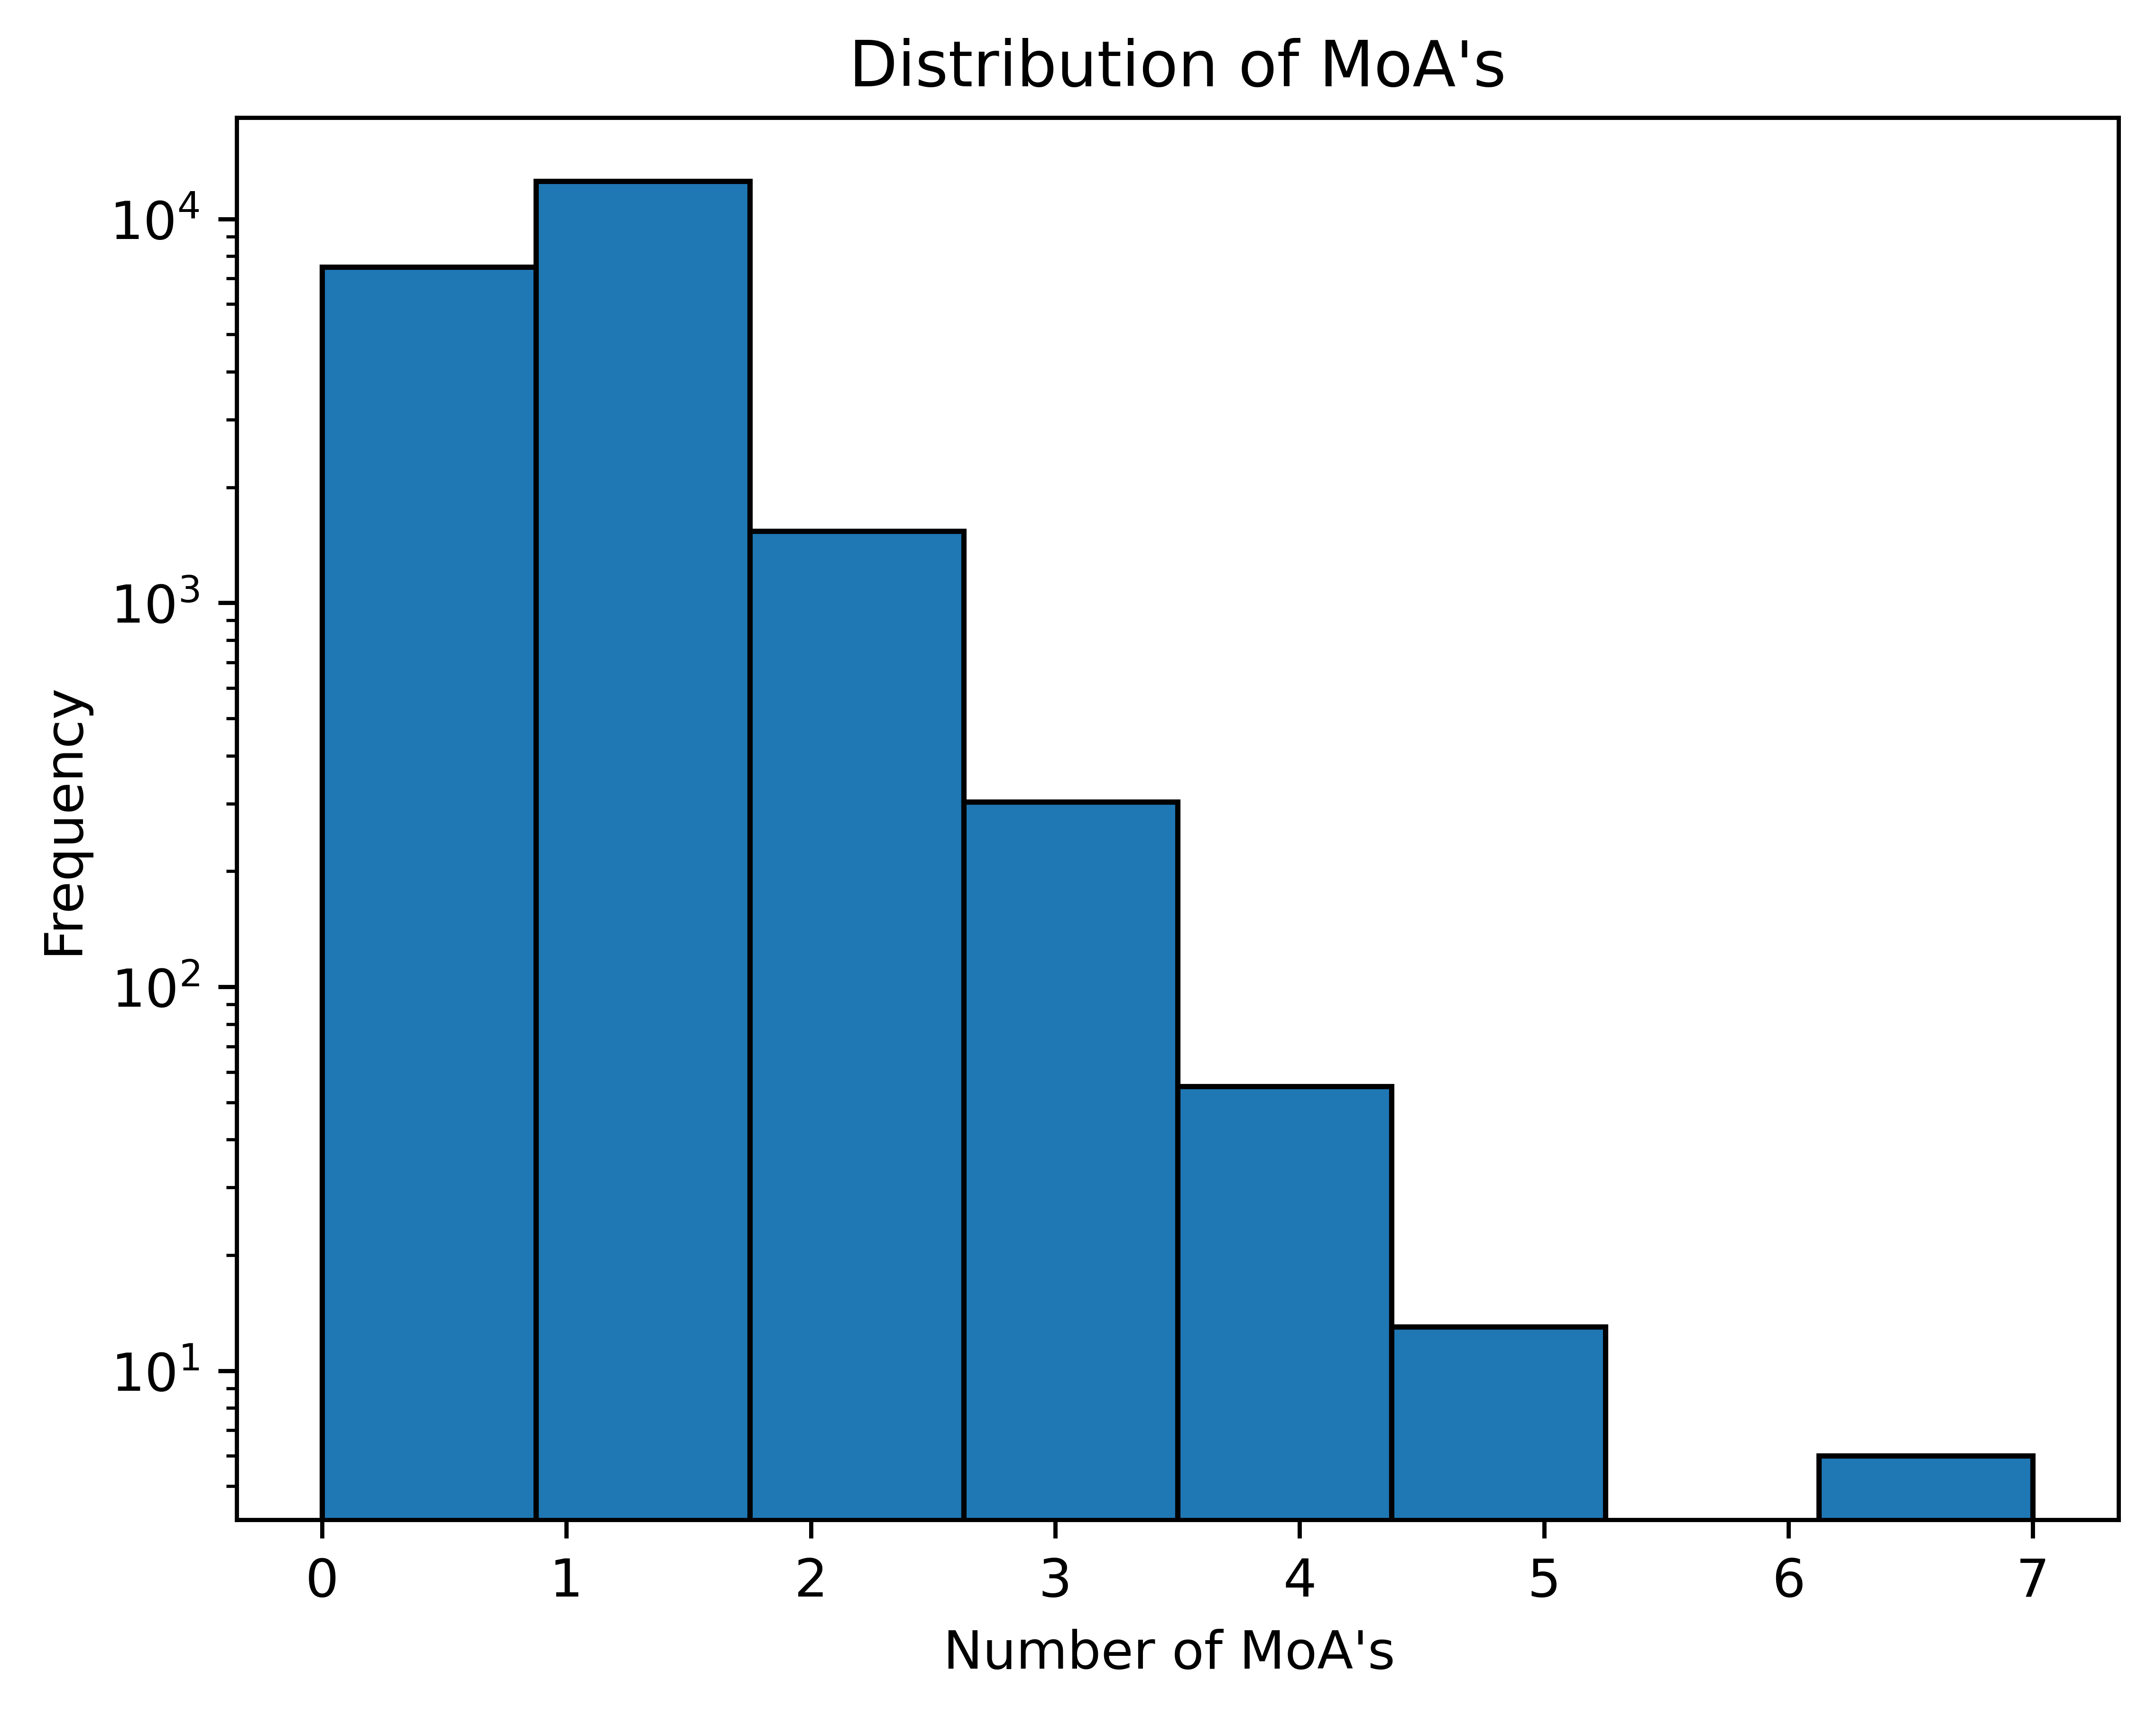

In [97]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

f = plt.figure(dpi=800)
disp_y = COMPLETE_y.iloc[:, 1:].to_numpy()
print(disp_y.shape)
row_sums = np.sum(disp_y, axis=1)

# Plot the distribution
plt.hist(row_sums, bins=8, align='mid', edgecolor='black')
plt.xlabel('Number of MoA\'s ')
plt.ylabel('Frequency')
plt.title('Distribution of MoA\'s')
plt.yscale('log')
plt.xticks(range(8))
plt.show()

/var/folders/t6/trtcfqfn7hn54kl7wh0yq33m0000gn/T/ipykernel_15843/4072788368.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(np.triu(COMPLETE_X.corr()), fignum=f.number, cmap='bwr', vmin=-1, vmax=1)


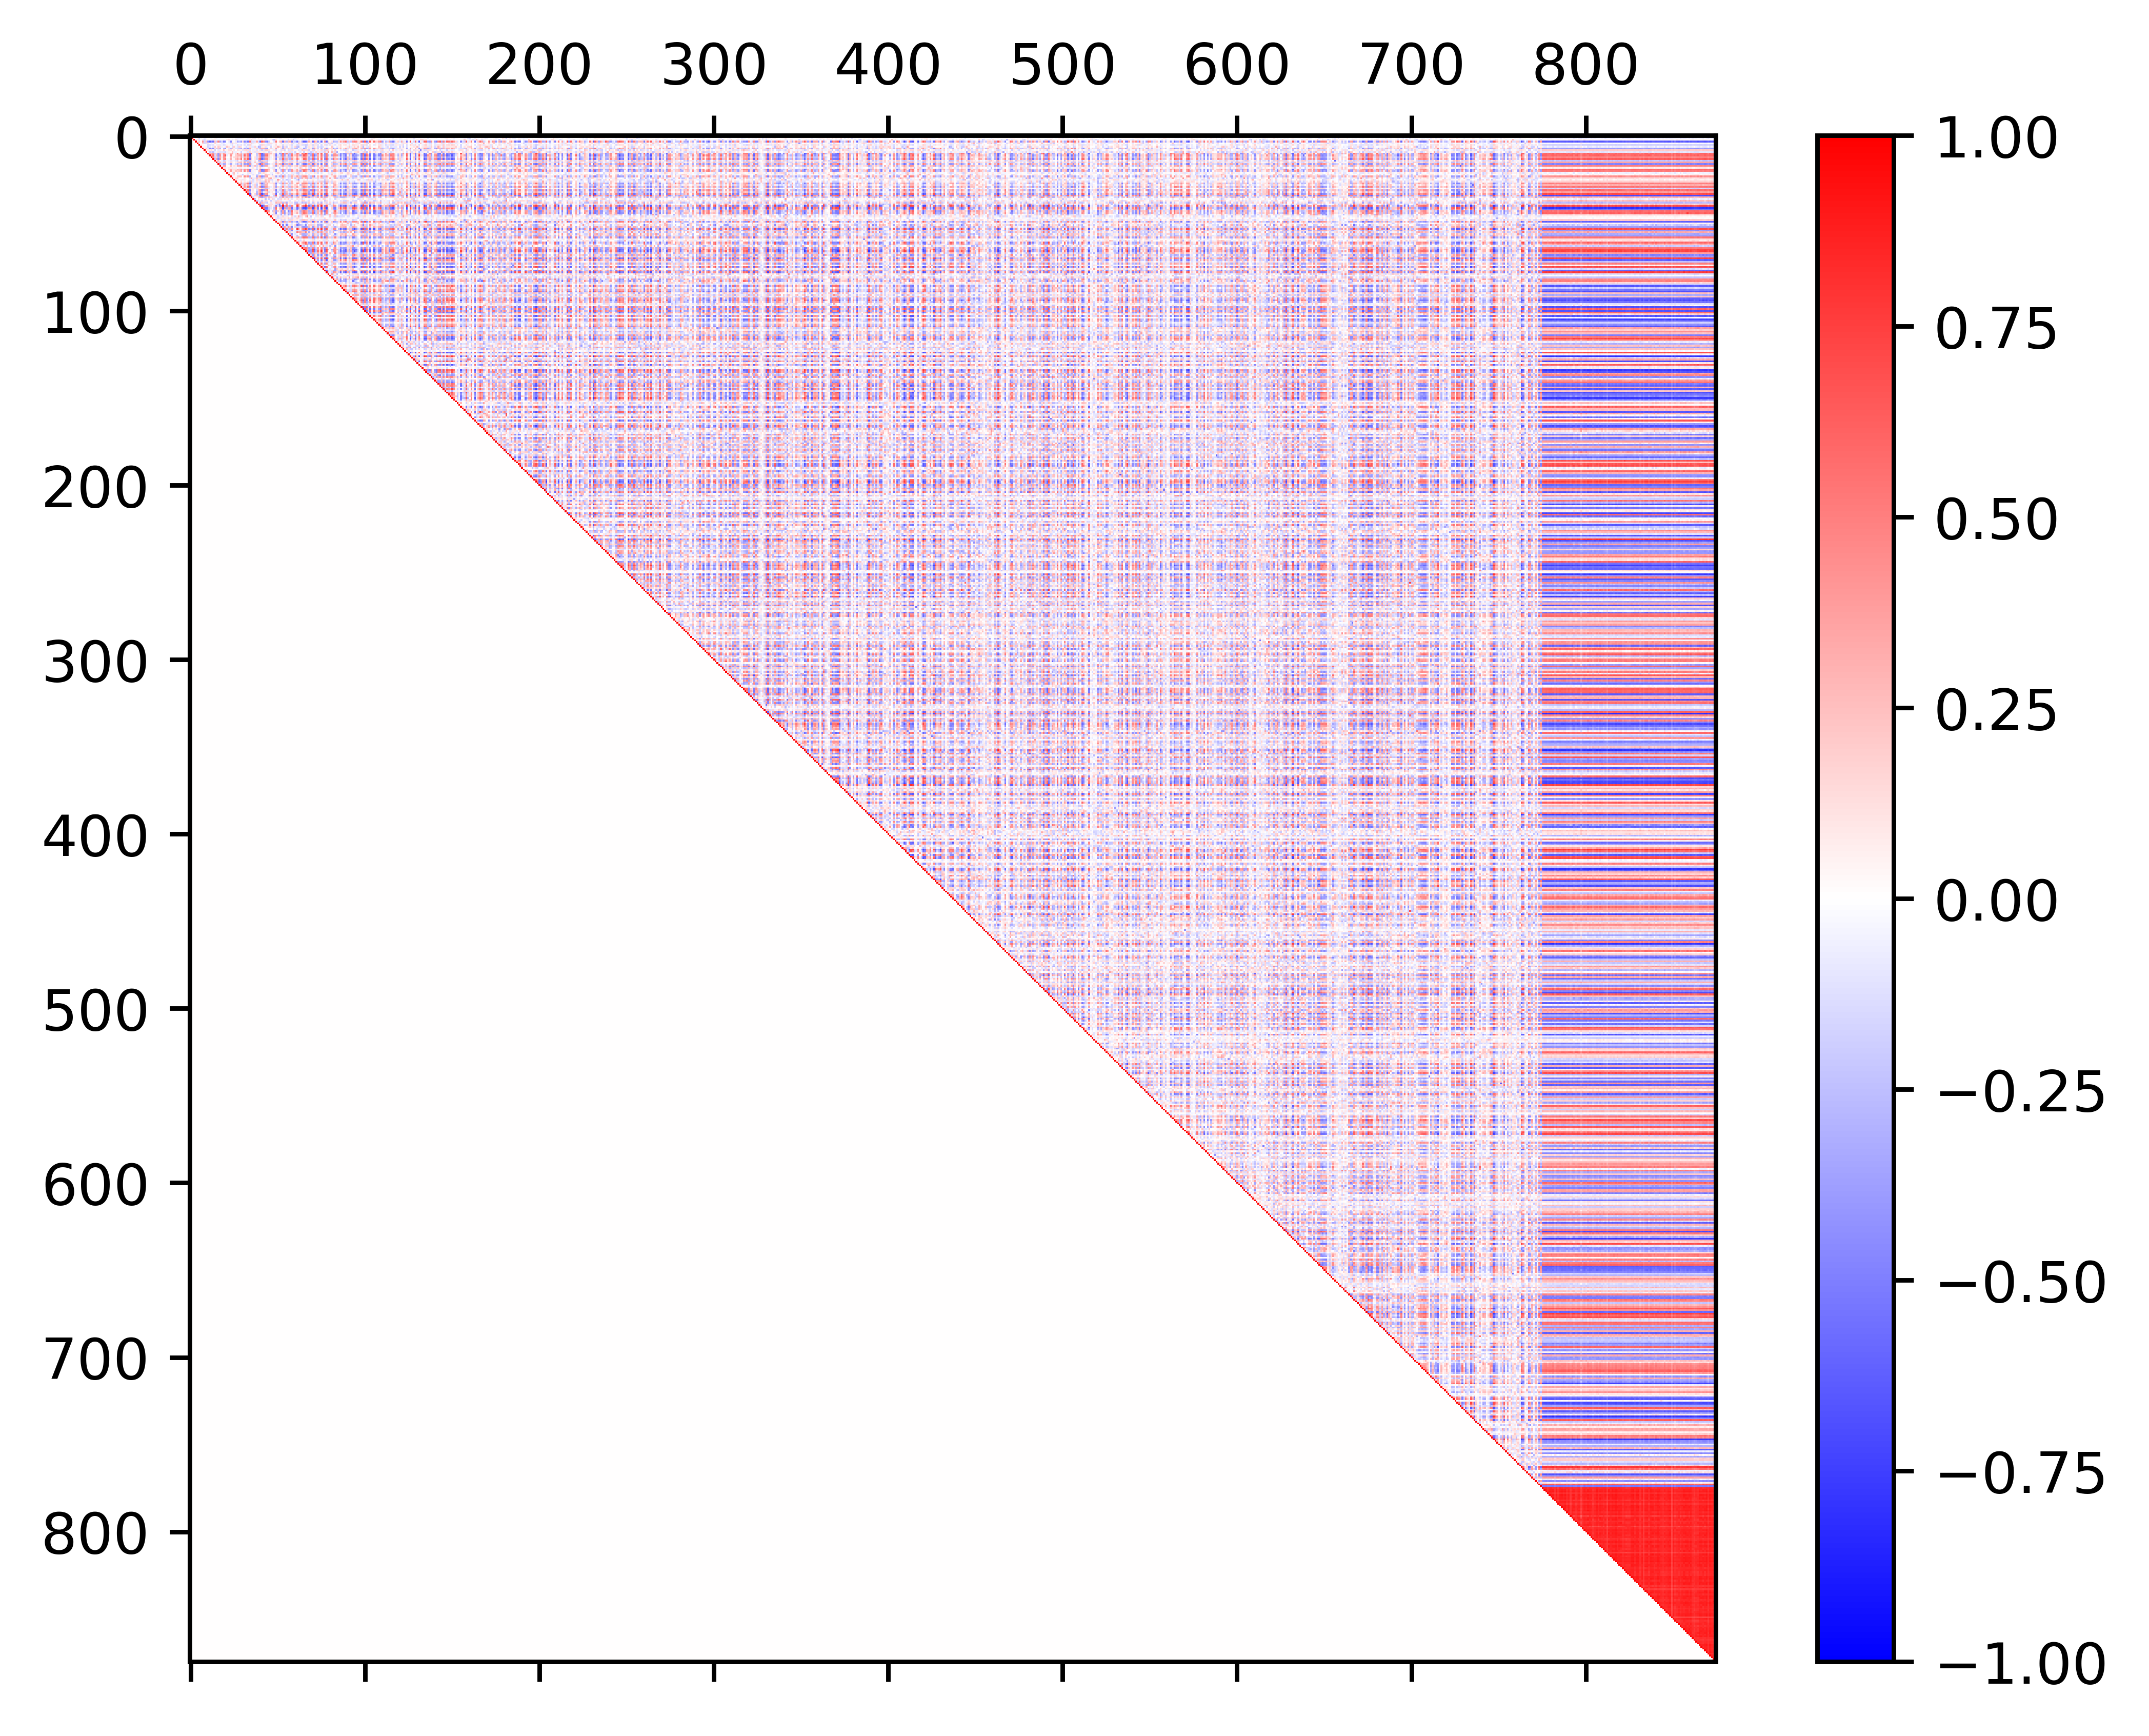

In [101]:
import matplotlib.pyplot as plt 
import pandas as pd 

f = plt.figure(dpi=800)
plt.matshow(np.triu(COMPLETE_X.corr()), fignum=f.number, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

min count: 1, max count: 832


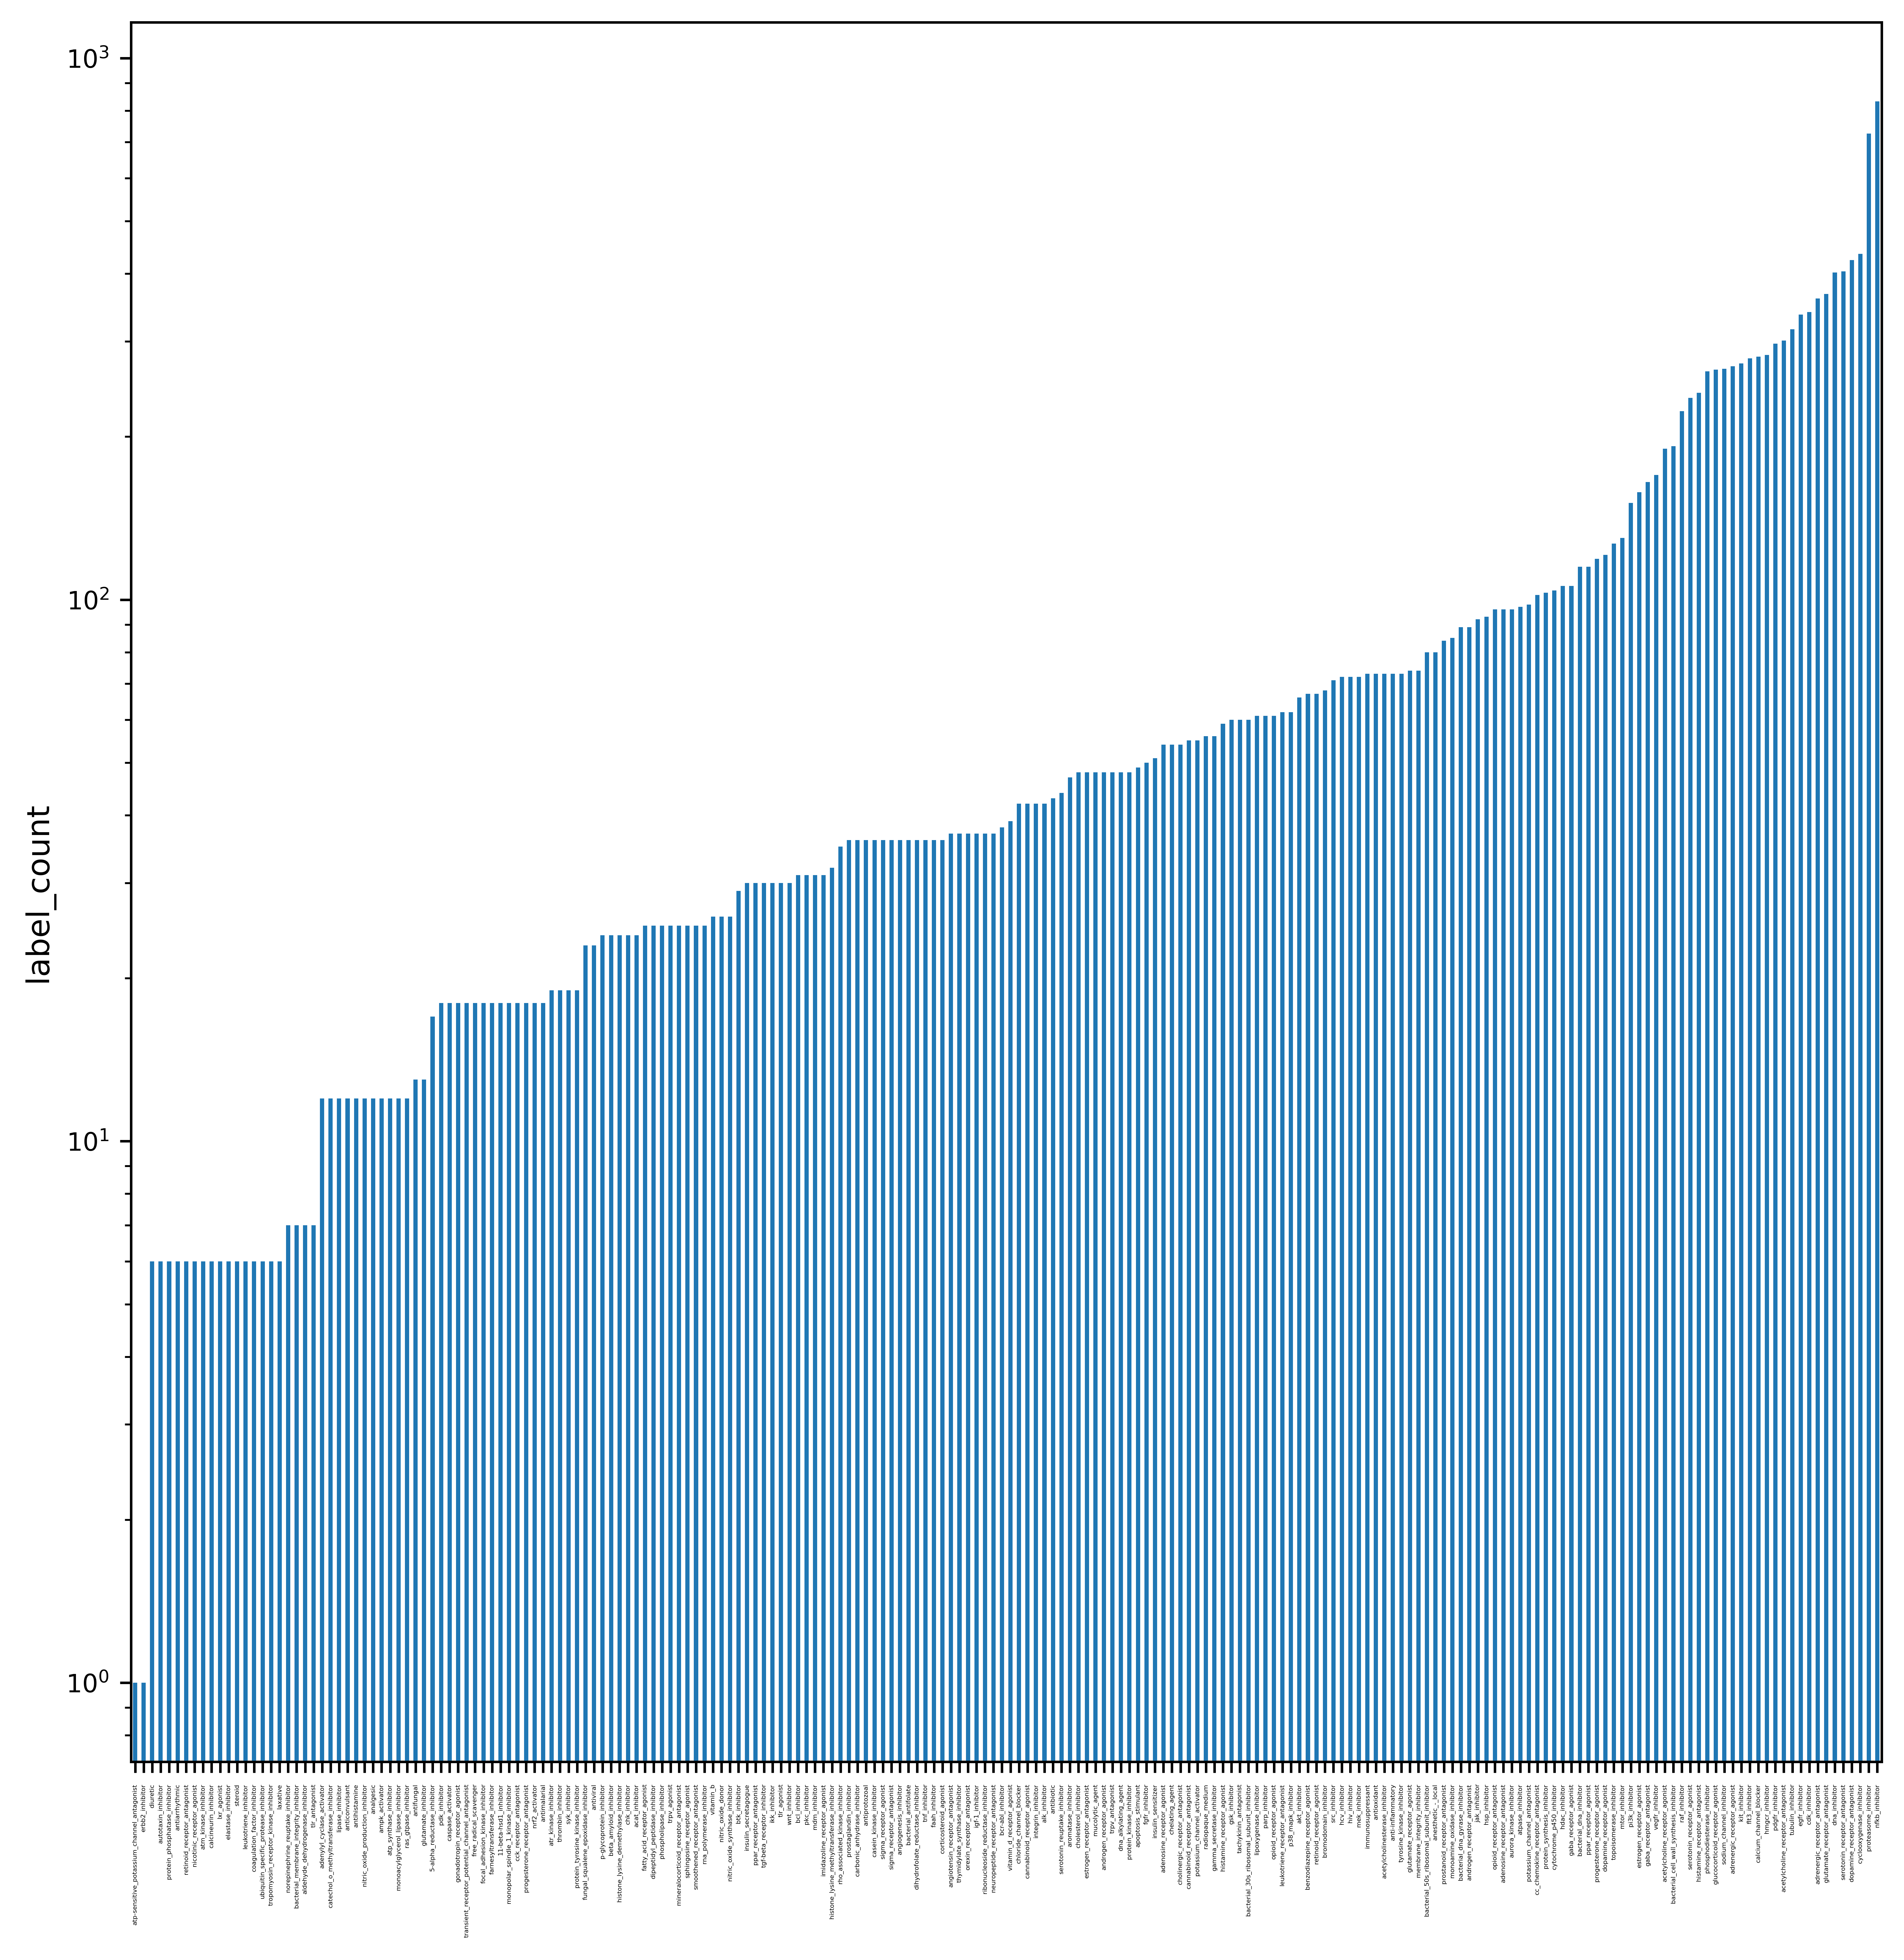

In [60]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10), dpi=800) #create figure object with high DPI because there are lots of column labels 

col_sums = COMPLETE_y.sum(axis=0).iloc[1:].sort_values() #take col sums to find number of examples 

print(f'min count: {col_sums.min()}, max count: {col_sums.max()}') #output min and max count of labels

col_sums.plot.bar(ylabel='label_count', fontsize=2) #plot
plt.yticks(fontsize=8)
plt.yscale('log')


In [61]:
import os 
import sys
import numpy as np 
import pandas as pd 
from xgboost import XGBClassifier 
from sklearn.model_selection import KFold, RandomizedSearchCV 
from category_encoders import CountEncoder 
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score, classification_report, jaccard_score, make_scorer
from sklearn.multioutput import MultiOutputClassifier


n_folds = 8 #num folds for Kfold cross validation


'''
NO HYPERPARAMETER TUNING
- we use just vanilla kfold cv with default hyperparameters 
'''
xgb_classifier = MultiOutputClassifier(XGBClassifier()) #using sklearn's pipeline to build a multilabel, multiclass classifier
model = Pipeline([ 
                  ('classify', xgb_classifier)]) #instantiate the pipeline object

kf = KFold(n_splits = n_folds) #instantiate a kfold CV object 



oof_losses = []
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'fold: {fold_idx}')
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
   # Fit RandomizedSearchCV on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    val_preds = model.predict_proba(X_val)
    
    val_preds = np.array(val_preds)[:,:,1].T # take the positive class

    loss = log_loss(np.ravel(y_val), np.ravel(val_preds)) #using log loss here not jaccard
    print(f'loss: {loss}')

    oof_losses.append(loss)

#try on test set 
test_preds = model.predict_proba(X_test) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 
mat_y_preds = np.round(test_preds)

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
print(report)

fold: 0
loss: 0.02381562650048329
fold: 1
loss: 0.02437359653736463
fold: 2
loss: 0.02445569754926001
fold: 3
loss: 0.023402136759907516
fold: 4
loss: 0.023843872255325728
fold: 5
loss: 0.02327726473459224
fold: 6
loss: 0.02375379115293028
fold: 7
loss: 0.02329327666210759
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3603708
           1       0.94      0.17      0.30     13446

    accuracy                           1.00   3617154
   macro avg       0.97      0.59      0.65   3617154
weighted avg       1.00      1.00      1.00   3617154



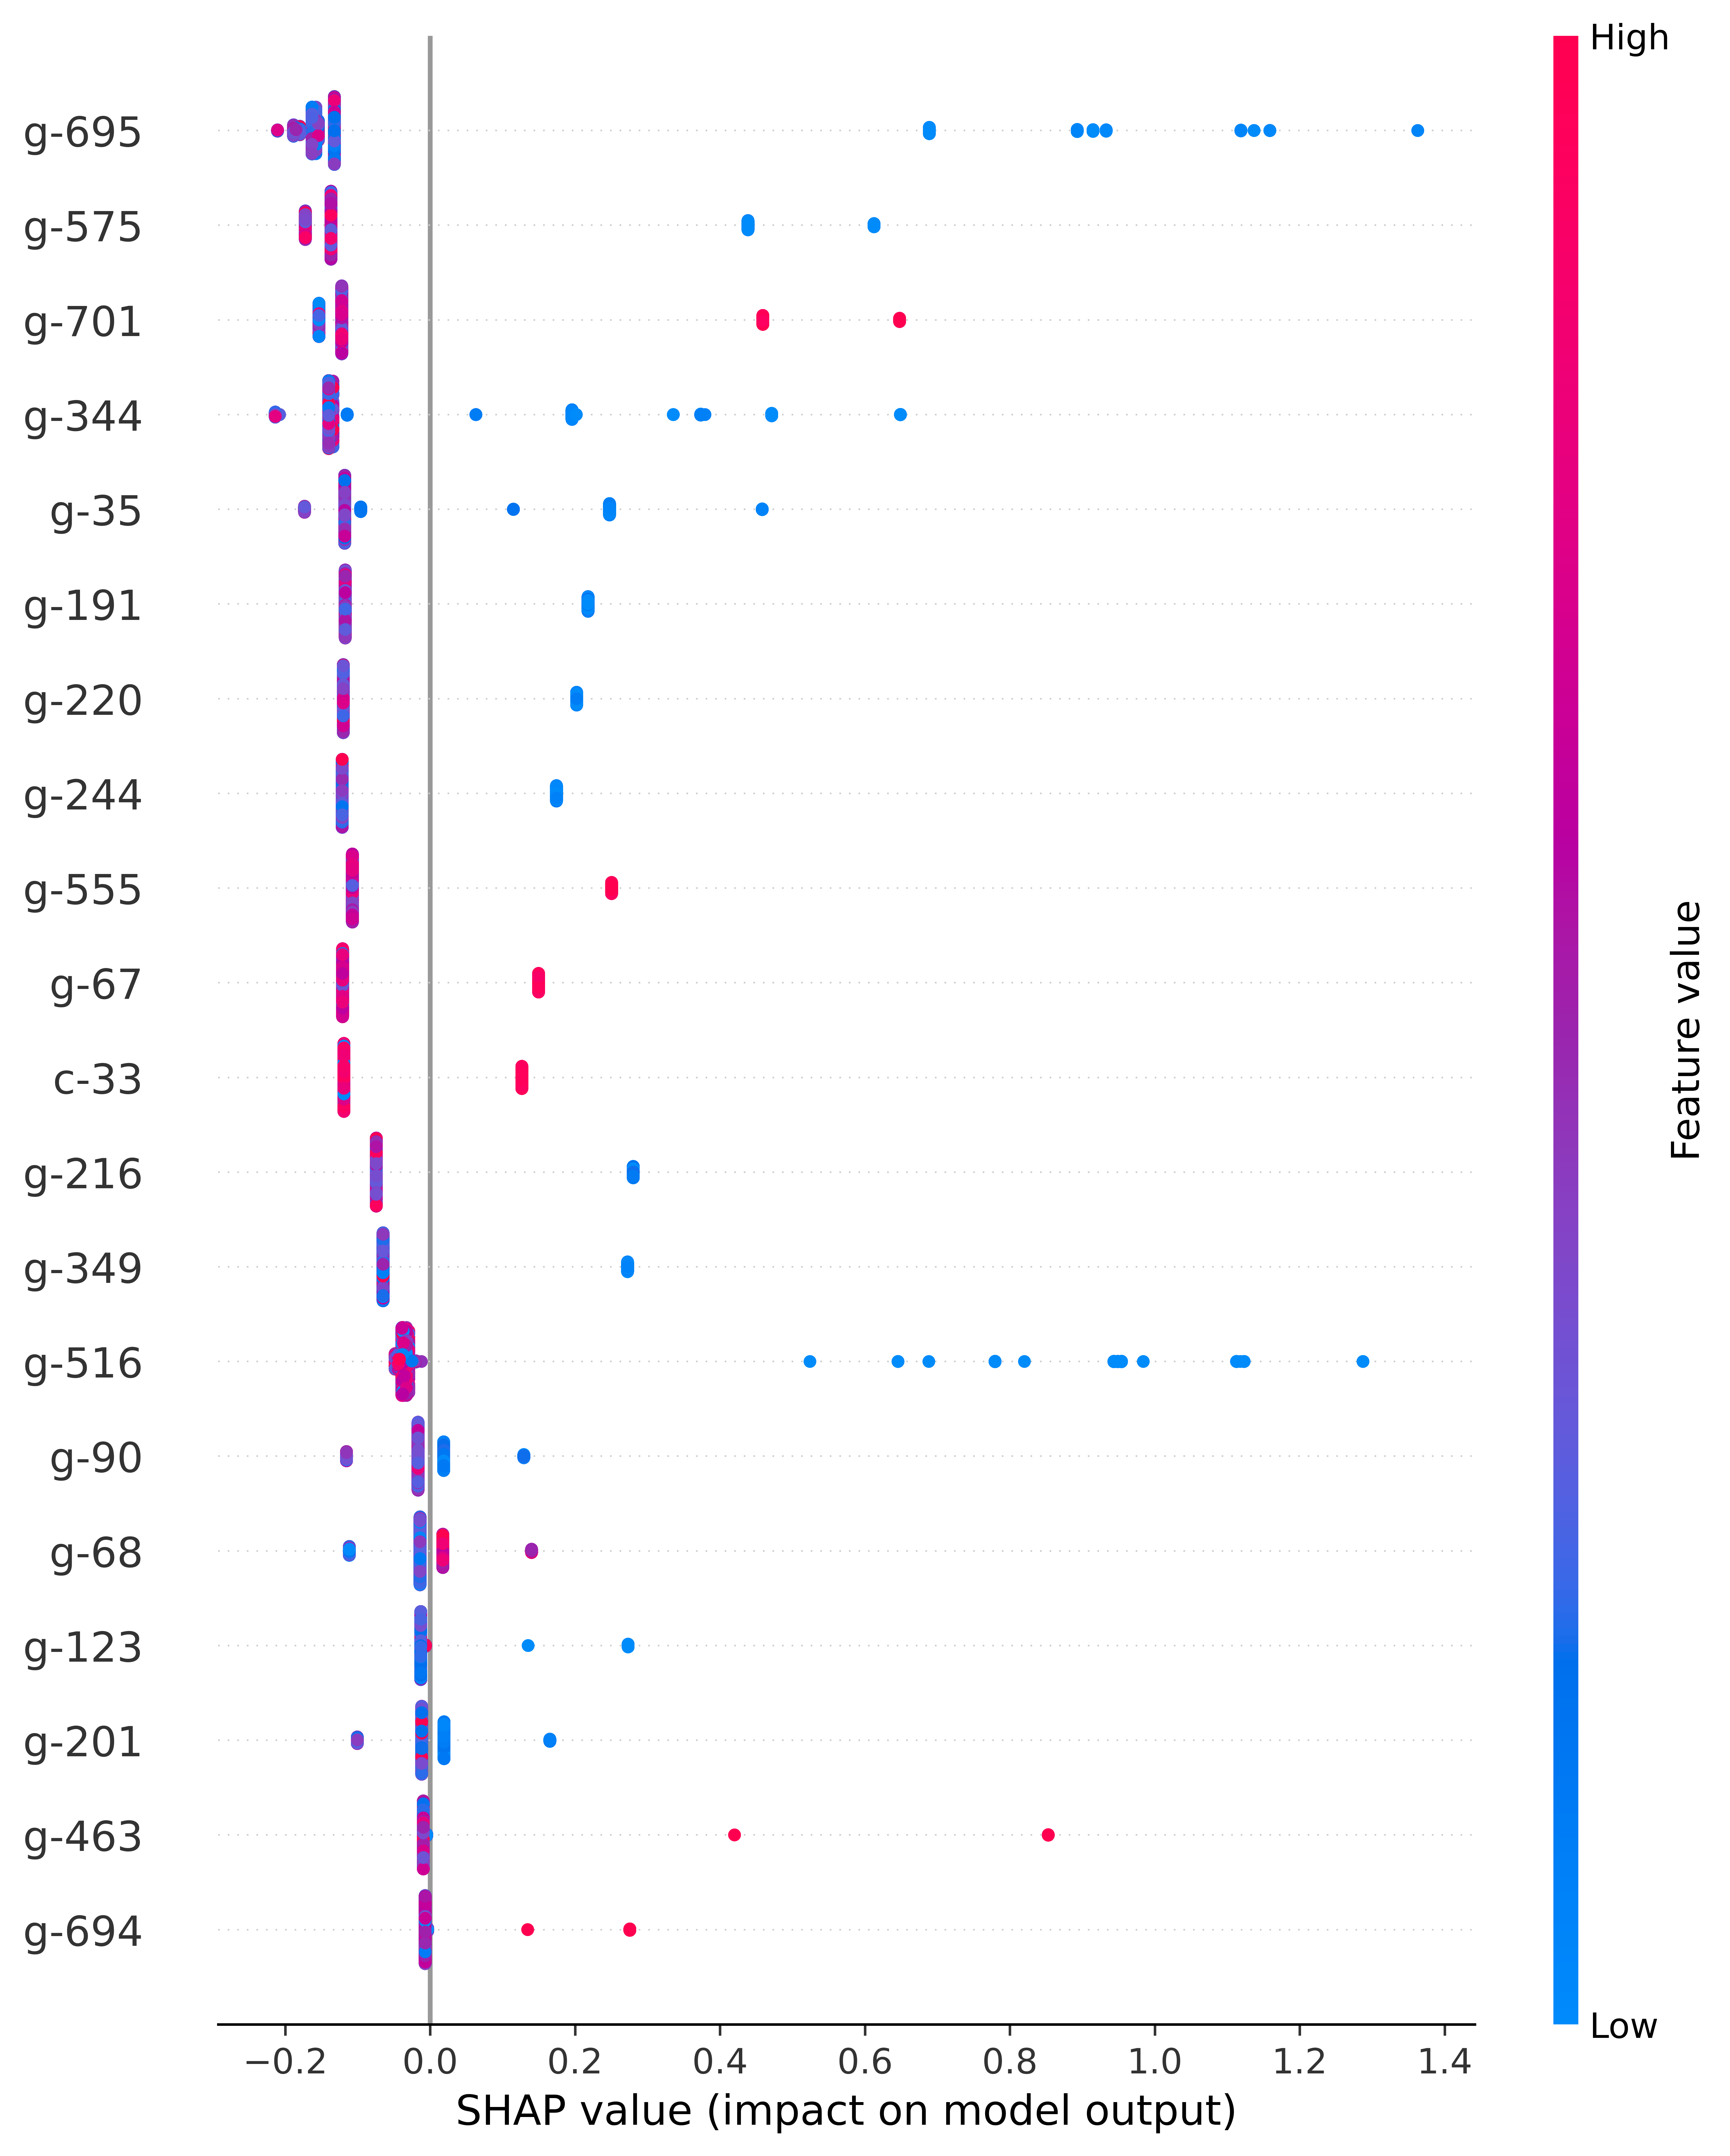

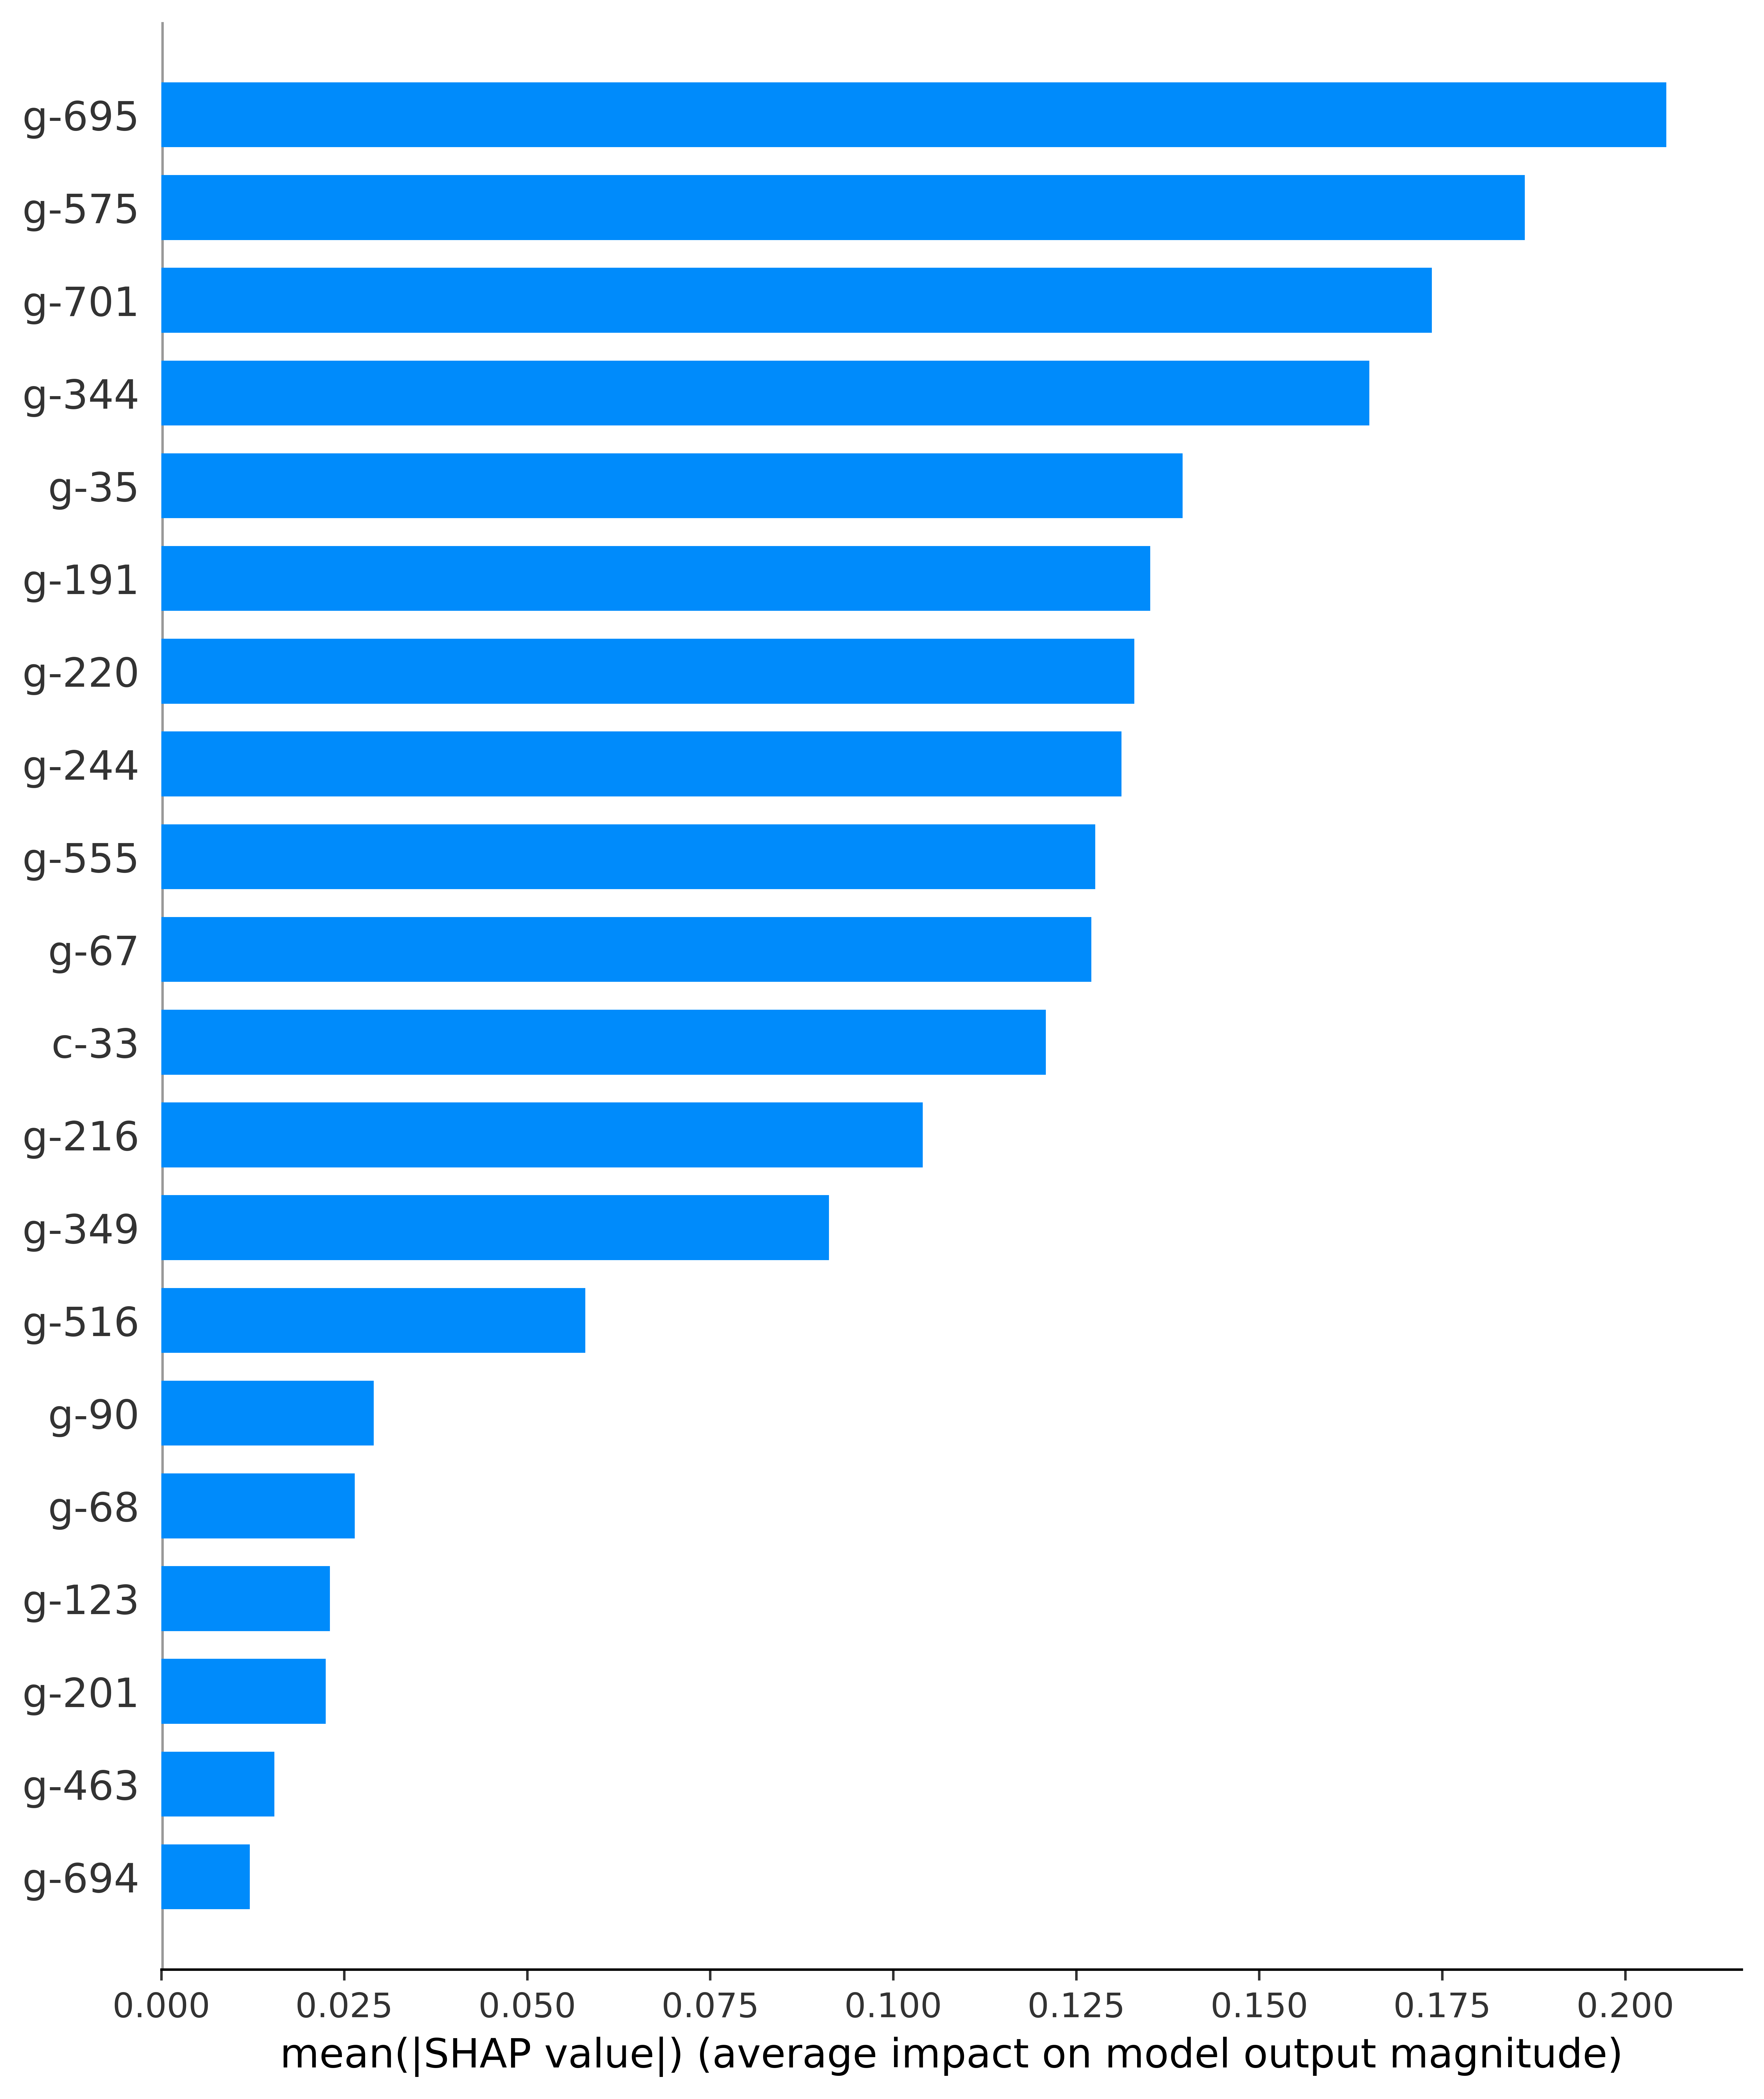

In [62]:
import shap 

#shap plot 
explainer = shap.TreeExplainer(model.named_steps['classify'].estimators_[87])
df_X = pd.DataFrame(X, columns=COMPLETE_X.columns[1::])
shap_values = explainer(df_X)
plt.figure(dpi=800)
shap.summary_plot(shap_values, X, show=False)
plt.figure(dpi=800)
shap.summary_plot(shap_values, df_X.values, plot_type="bar", class_names= df_X.columns, feature_names = df_X.columns)

# shap.plots.beeswarm(shap_values)


In [ ]:
'''
- parameter grid, we elect to modify the max_depth, learning_rate and n_estimators 
'''

'''GBT WITH HYPERPARAMETER TUNING'''

param_grid = {
    'classify__estimator__max_depth': np.linspace(0, 10, 11).astype(int),
    'classify__estimator__learning_rate': [10 ** -i for i in range(4)],
    'classify__estimator__n_estimators': [i*100 for i in range(5)]
}

xgb_classifier = MultiOutputClassifier(XGBClassifier()) #using sklearn's pipeline to build a multilabel, multiclass classifier

model = Pipeline([ 
                  ('classify', xgb_classifier)]) #instantiate the pipeline object

kf = KFold(n_splits = n_folds) #instantiate a kfold CV object 

'''
- We use random_search to not explore the whole parameter space, n_iter gives the number of param combinations used, can alternatively use GridSearchCV
- Jaccard scoring appears to be a good metric for a multilabel multiclass problem, can read more at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
''' 

jaccard_scorer = make_scorer(jaccard_score, average='macro', zero_division=0.0) #define custom scoring function
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=1, cv=kf, scoring=jaccard_scorer, verbose=10, n_jobs=-1)
random_search.fit(X, y)# Fit RandomizedSearchCV on the training data
best_model = random_search.best_estimator_ # Get the best model from RandomizedSearchCV


test_preds = best_model.predict_proba(X_test) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 
mat_y_preds = np.round(test_preds)

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
print(report)


# Neural Network 